Can we create an encoder-decoder model for character data that acts as an embedding layer?

If we could, our models could just predict the embedding, which may then be decoded to generate the word. For example, our decoder could just predict a 100D vector for each timestamp, which represents the word.

Don't reset our GRU state as we read in characters?

Plan:

* Load Glove Embeddings.
* Load text.
* Tokenize text > words.
* For each word - build an encoder:
    * Clean characters.
    * Add control characters to start and end > convert to numbers.
    * Batch by length of word - 0-5,5-10,10-20, 20+ (or cap /arbitrarily break at 20?)
    * Set as GRU sequences;
    * Set Y as embedding for word;
    * Use MSE loss and train.
* Also build a decoder:
    * Input initial state = embedding. Token = start sequence.
    * Train with input sequence char + output sequence char shifted by one.

In [2]:
import pickle
import os

PIK = "claim_and_title.data"

if not os.path.isfile(PIK):
    # Download file
    !wget https://benhoyle.github.io/notebooks/title_generation/claim_and_title.data

with open(PIK, "rb") as f:
    print("Loading data")
    data = pickle.load(f)
    print("{0} samples loaded".format(len(data)))

Loading data
30000 samples loaded


In [3]:
from nltk import word_tokenize

In [4]:
# Tokenize words
data_as_words = [word_tokenize(d[0].lower().strip()) for d in data]

In [9]:
data_as_words[0][0:10]

['1.',
 'a',
 'method',
 'for',
 'managing',
 'a',
 'backup',
 'service',
 'gateway',
 '(']

In [5]:
# Filter out non-words
data_as_words = [word for claim in data_as_words for word in claim if word.isalpha()]

In [6]:
print("We have {} words.".format(len(data_as_words)))

We have 6268278 words.


In [18]:
data_as_words[0:10]

['a',
 'method',
 'for',
 'managing',
 'a',
 'backup',
 'service',
 'gateway',
 'sgw',
 'associated']

In [7]:
import numpy as np

# Load Glove Embeddings
print("Loading GloVe 100d embeddings from file")
GLOVE_DIR = "glove/"

embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), 'rb')
for line in f:
    values = line.split()
    # Tweaked to decode the binary text values
    word = values[0].decode('utf-8')
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

Loading GloVe 100d embeddings from file


In [10]:
# Setup character vocab 
import string
char_vocab = ["_PAD_", "_SOW_", "_EOW_"] + list(string.ascii_lowercase)
print("There are {} character tokens".format(len(char_vocab)))

There are 29 character tokens


In [11]:
# Convert words to ints
# Build dictionaries
reverse_dict = {i: c for i, c in enumerate(char_vocab)}
forward_dict = {v: k for k, v in reverse_dict.items()}

In [12]:
# Generate embedding - character list pairs
dataset = []
for word in data_as_words:
    embedding = embeddings_index.get(word, None)
    if embedding is not None:
        try:
            word_as_int = [forward_dict["_SOW_"]] + [forward_dict[c] for c in word] + [forward_dict["_EOW_"]]
            dataset.append((embedding, word_as_int))
        except KeyError:
            continue
        

In [35]:
print("There are now {0} entries in the dataset".format(len(dataset)))
dataset[1]

There are now 6251296 entries in the dataset


(array([-4.1796e-01,  5.3241e-01, -3.3693e-01,  6.9262e-01,  6.8686e-02,
        -8.7566e-02,  2.7663e-01, -7.1203e-02, -3.3530e-01,  3.3365e-01,
        -5.2407e-01, -5.3341e-01,  4.0460e-02, -1.6659e-01,  4.5481e-01,
        -3.4785e-01,  2.4926e-01,  2.2734e-02,  4.2120e-01,  6.2452e-03,
        -1.3359e-01, -5.1309e-01,  2.1382e-01, -2.4943e-01, -3.6553e-01,
        -1.0690e-02,  2.5961e-01, -2.9090e-01, -7.6780e-01,  3.7387e-02,
        -4.6895e-01,  8.9278e-01, -5.3101e-01, -3.8841e-01,  3.5913e-01,
        -4.7930e-01, -3.3601e-01, -2.0371e-01,  3.9182e-01, -9.5175e-01,
        -6.2779e-01,  1.7753e-01, -3.5282e-02, -1.2463e-01, -8.4179e-01,
        -3.4632e-01, -1.9631e-01, -8.4428e-01, -5.4253e-01, -1.9322e-01,
         2.5287e-01, -1.2990e-02, -1.4000e-03,  1.4574e+00, -7.6291e-01,
        -1.5731e+00, -2.3982e-01,  2.2269e-01,  8.7785e-01, -3.4078e-02,
        -3.6702e-02, -3.1008e-01,  8.0324e-01,  6.1032e-01,  1.3546e+00,
        -1.4522e-01, -1.9501e-01, -6.8654e-01, -9.6

In [ ]:
# char_emb_dim = 8
#decoder_embedding = Embedding(input_dim = num_decoder_tokens, output_dim=char_emb_dim)(decoder_inputs)

To cut a long story short - we need to use one-hot encodings of our character data for our decoder inputs and outputs. As there are around 6m samples, we need to break up our training data into batches (we have matrices of 6m, 20, 29). As we need to break our training data into batches, we can maybe create batches of different sizes.

In [103]:
from keras.layers import GRU, Input, Dense, Embedding
from keras.models import Model

embedding_dim = 100
num_decoder_tokens = len(char_vocab)
# Limit word length to 20
decoder_seq_length = 20

encoded_state = Input(shape=(embedding_dim,), name="EncodedState")
decoder_inputs = Input(shape=(None, num_decoder_tokens), name="DecoderInputs")
decoder_gru = GRU(embedding_dim, return_sequences=True, name="Decoder")
decoder_outputs = decoder_gru(decoder_inputs, initial_state=encoded_state)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name="VocabProjection")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoded_state, decoder_inputs], decoder_outputs)

model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )

In [86]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(model, show_shapes=True).create_png(prog='dot'))

ImportError: Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.

In [92]:
def inputs_to_one_hot(input_seqs, decoder_seq_length, num_decoder_tokens):
    """ Convert a sequence of integers to normal and shifted one-hot representations a one element shifted
        sequence of one-hot vectors."""
    length = len(input_seqs)
    one_hot_in = np.zeros(
            (length, decoder_seq_length, num_decoder_tokens)
            )
    one_hot_out = np.zeros(
            (length, decoder_seq_length, num_decoder_tokens)
            )
    for i, sequence in enumerate(input_seqs):
        for timestamp, word_int in enumerate(sequence):
            one_hot_in[i, timestamp, word_int] = 1
            if timestamp > 0:
                # Shift decoder target get so it is one ahead
                one_hot_out[i, timestamp-1, word_int] = 1
    return one_hot_in, one_hot_out

With embedding for characters.
```
from keras.layers import GRU, Input, Dense, Embedding
from keras.models import Model

embedding_dim = 100
num_decoder_tokens = len(char_vocab)
# Limit word length to 20
decoder_seq_length = 20
# Character embedding dimension
char_emb_dim = 8

encoded_state = Input(shape=(embedding_dim,), name="EncodedState")
decoder_inputs = Input(shape=(None, ), name="DecoderInputs")
decoder_embedding = Embedding(input_dim = num_decoder_tokens, output_dim=char_emb_dim)(decoder_inputs)
decoder_gru = GRU(embedding_dim, return_sequences=True, name="Decoder")
decoder_outputs = decoder_gru(decoder_embedding, initial_state=encoded_state)
decoder_dense = Dense(num_decoder_tokens, activation='softmax', name="VocabProjection")
decoder_outputs = decoder_dense(decoder_outputs)
model = Model([encoded_state, decoder_inputs], decoder_outputs)
```


Our longest sequence is 24 tokens long.


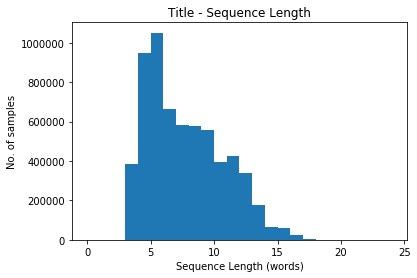

In [45]:
import matplotlib.pyplot as plt

%matplotlib inline

# Let's have a look at our word length distribution
Y_length = [len(y) for e, y in dataset]
max_y_length = max(Y_length)
print("Our longest sequence is {0} tokens long.".format(max_y_length))

bins = np.linspace(0, max_y_length, 25)
plt.hist(Y_length, bins)
plt.title('Title - Sequence Length')
plt.ylabel('No. of samples')
plt.xlabel('Sequence Length (words)')
plt.show()

In [94]:
# Shall we try using the keras to_categorial method and then shift this as before
# To test our model works we'll just select the first 500k sampes
decoder_in_seqs = [y for e,y in dataset[0:50000]]
decoder_in_seqs, decoder_out_seqs = inputs_to_one_hot(decoder_in_seqs, decoder_seq_length, num_decoder_tokens)

In [95]:
print(decoder_in_seqs.shape, decoder_out_seqs.shape)

(50000, 20, 29) (50000, 20, 29)


In [ ]:
# Here we split our data into batches of different lengths - we can then compute our shifted output vector

In [58]:
# Note - with ints we can use just array slicing to shift
# Could we build one hot conversion into model as a layer? Would save having to convert all the data first
# decoder_out_seqs = np.zeros(decoder_in_seqs.shape, dtype='int32')
# decoder_out_seqs[:, 0:19] = decoder_in_seqs[:, 1:20]
# decoder_out_seqs.shape

In [96]:
encoded_states = np.array([e for e, y in dataset[0:50000]])

In [97]:
encoded_states.shape

(50000, 100)

In [105]:
callback = model.fit([encoded_states, decoder_in_seqs], decoder_out_seqs, validation_split=0.1, batch_size=64, epochs=100)

Train on 45000 samples, validate on 5000 samples
Epoch 1/100
45000/45000 [==============================] - 24s 523us/step - loss: 0.3078 - acc: 0.2275 - val_loss: 0.2953 - val_acc: 0.2339
Epoch 2/100
45000/45000 [==============================] - 23s 519us/step - loss: 0.2238 - acc: 0.2523 - val_loss: 0.2541 - val_acc: 0.2459
Epoch 3/100
45000/45000 [==============================] - 24s 524us/step - loss: 0.1766 - acc: 0.2657 - val_loss: 0.2285 - val_acc: 0.2539
Epoch 4/100
45000/45000 [==============================] - 23s 522us/step - loss: 0.1460 - acc: 0.2744 - val_loss: 0.2124 - val_acc: 0.2604
Epoch 5/100
45000/45000 [==============================] - 23s 521us/step - loss: 0.1247 - acc: 0.2808 - val_loss: 0.2050 - val_acc: 0.2630
Epoch 6/100
45000/45000 [==============================] - 24s 523us/step - loss: 0.1091 - acc: 0.2850 - val_loss: 0.1967 - val_acc: 0.2672
Epoch 7/100
45000/45000 [==============================] - 23s 522us/step - loss: 0.0972 - acc: 0.2882 - val_lo

KeyboardInterrupt: 

### Comments on Initial Training

This seems to reach a local minima within 10 epochs.

Now we need to code up our loop through the 6million examples in sets of 100k. We'll need to initially create different test and training datasets that we keep separate. Can we use / edit our existing models?

What does training do? It captures information about two things:

* The data values themselves (e.g. character sequences per word); and
* The distribution of the words in the dataset.



In [13]:
input_data = [e for e, y in dataset]
output_data = [y for e, y in dataset]

In [14]:
from char_gen import CharS2S

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


We want to build an abstract class that has the encoder and decoder systems as separate replaceable modules. E.g. process_encoder_input, process_decoder_input.

In [66]:
char_s2s = CharS2S(
    encoder_states=input_data,
    decoder_seqs=output_data,
    decoder_seq_length=20,
    latent_dim=100,
    weights_file="charstate2seq.hdf5",
    training_set_size=50000,  # Due to memory we need to train in sets
    batch_size=128
)

Building model
Loaded weights
Generating training and test data


Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 22s 439us/step - loss: 0.6185 - acc: 0.1368 - val_loss: 0.4443 - val_acc: 0.1886
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 380us/step - loss: 0.3761 - acc: 0.2077 - val_loss: 0.3261 - val_acc: 0.2227
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 374us/step - loss: 0.2954 - acc: 0.2294 - val_loss: 0.2736 - val_acc: 0.2381
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 374us/step - loss: 0.2524 - acc: 0.2438 - val_loss: 0.2303 - val_acc: 0.2492
Training on batch 200000 to 250000 of 5001036
Trai

Training on batch 1750000 to 1800000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 375us/step - loss: 0.0844 - acc: 0.2892 - val_loss: 0.0857 - val_acc: 0.2902
Training on batch 1800000 to 1850000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 373us/step - loss: 0.0806 - acc: 0.2912 - val_loss: 0.0788 - val_acc: 0.2912
Training on batch 1850000 to 1900000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 376us/step - loss: 0.0802 - acc: 0.2903 - val_loss: 0.0801 - val_acc: 0.2916
Training on batch 1900000 to 1950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 20s 392us/step - loss: 0.0796 - acc: 0.2908 - val_loss: 0.0789 - val_acc: 0.2917
Training on batch 1950000 to 2000000 of 5001036
Train on

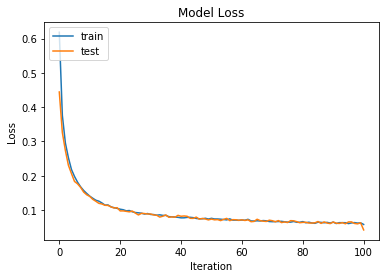

In [121]:
char_s2s.train()

```
Training on batch 4950000 to 5000000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 20s 392us/step - loss: 0.0625 - acc: 0.2959 - val_loss: 0.0627 - val_acc: 0.2938
```

Now we need to look at what this is generating!

It is noted that the accuracy is only 30% - it would be interested to see how this is manifesting.

In [190]:
char_s2s.print()

Training Model:

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
DecoderInputs (InputLayer)      (None, None, 29)     0                                            
__________________________________________________________________________________________________
EncodedState (InputLayer)       (None, 100)          0                                            
__________________________________________________________________________________________________
Decoder (GRU)                   [(None, None, 100),  39000       DecoderInputs[0][0]              
                                                                 EncodedState[0][0]               
__________________________________________________________________________________________________
VocabProjection (Dense)         (None, None, 29)     2929        Decoder[0][0]              

Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0599 - acc: 0.2965 - val_loss: 0.0595 - val_acc: 0.2963
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0610 - acc: 0.2957 - val_loss: 0.0595 - val_acc: 0.2956
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 384us/step - loss: 0.0630 - acc: 0.2945 - val_loss: 0.0650 - val_acc: 0.2967
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0632 - acc: 0.2965 - val_loss: 0.0595 - val_acc: 0.2960
Training on batch 200000 to 250000 of 5001036
Trai

Training on batch 1750000 to 1800000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 383us/step - loss: 0.0588 - acc: 0.2964 - val_loss: 0.0599 - val_acc: 0.2971
Training on batch 1800000 to 1850000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0577 - acc: 0.2974 - val_loss: 0.0571 - val_acc: 0.2971
Training on batch 1850000 to 1900000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0577 - acc: 0.2963 - val_loss: 0.0571 - val_acc: 0.2984
Training on batch 1900000 to 1950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 387us/step - loss: 0.0554 - acc: 0.2973 - val_loss: 0.0561 - val_acc: 0.2978
Training on batch 1950000 to 2000000 of 5001036
Train on

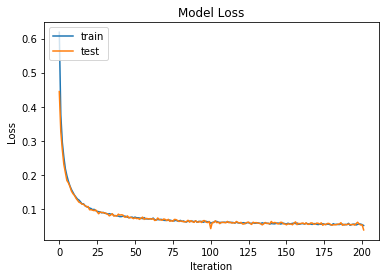

In [123]:
char_s2s.train()

```
Training on batch 4900000 to 4950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 390us/step - loss: 0.0552 - acc: 0.2987 - val_loss: 0.0527 - val_acc: 0.2954
Training on batch 4950000 to 5000000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 19s 386us/step - loss: 0.0537 - acc: 0.2984 - val_loss: 0.0531 - val_acc: 0.2967
```

In [68]:
char_s2s.example_output(100)

------------------------------------------
Predicted word is: c o n t e r r e s 
Actual word is: e v e n t s  
---
Predicted word is: s a i d 
Actual word is: s a i d  
---
Predicted word is: w h e r e i n 
Actual word is: w h e r e i n  
---
Predicted word is: d a t a 
Actual word is: d a t a  
---
Predicted word is: p r o g r a m m i n g 
Actual word is: p r o g r a m m i n g  
---
Predicted word is: r e f e r e n c e 
Actual word is: r e f e r e n c e  
---
Predicted word is: m o s t a l r s 
Actual word is: s e t t i n g s  
---
Predicted word is: w h i c h 
Actual word is: w h i c h  
---
Predicted word is: o f 
Actual word is: o f  
---
Predicted word is: b u n t l u e d 
Actual word is: m e c h a n i c  
---
Predicted word is: b a s e d 
Actual word is: b a s e d  
---
Predicted word is: a n d 
Actual word is: a n d  
---
Predicted word is: r a t i n g 
Actual word is: r a t i n g  
---
Predicted word is: i n 
Actual word is: i n  
---
Predicted word is: c l i e n t 
Actual word

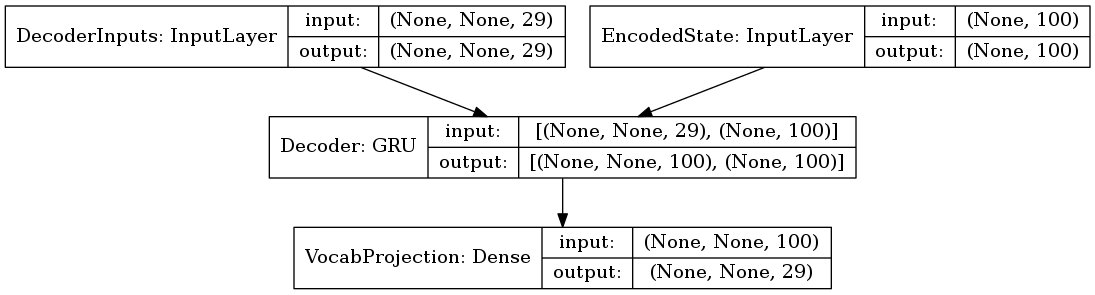

In [192]:
from keras.utils.vis_utils import model_to_dot
from IPython.display import Image
Image(model_to_dot(self.model, show_shapes=True).create_png(prog='dot'))

Ideas for improving performance:
* Adding more hidden layers.
* Bidirectional iterations.
* Projecting embedding to a greater dimensionality then applying a larger GRU.
* Beam search on decoding.
* Bidirectional GRU - https://keras.io/layers/wrappers/#bidirectional - work forwards and backwards

In [15]:
from keras.layers import GRU, Input, Dense
from keras.models import Model

new_latent_dim = 512

class CharS2S_ext(CharS2S):
    def _build_model(self):
        """ Build the model. """
        print("Building model")
        encoded_state = Input(shape=(self.latent_dim,), name="EncodedState")
        projected_state = Dense(new_latent_dim, activation='relu', name="ProjectState")(encoded_state)
        
        decoder_inputs = Input(shape=(None, self.num_decoder_tokens), name="DecoderInputs")
        
        decoder_gru = GRU(new_latent_dim, return_sequences=True, return_state=True, name="Decoder")
        decoder_outputs, decoder_state = decoder_gru(decoder_inputs, initial_state=projected_state)
        
        decoder_dense = Dense(self.num_decoder_tokens, activation='softmax', name="VocabProjection")
        decoder_outputs = decoder_dense(decoder_outputs)
        
        decoder_state = Dense(self.latent_dim, name="ProjectDownState")(decoder_state)
        
        self.model = Model([encoded_state, decoder_inputs], decoder_outputs)

        # We also need an inference model
        self.infdec = Model(inputs=[encoded_state, decoder_inputs], outputs=[decoder_outputs, decoder_state])

        self.model.compile(
            optimizer='adam',
            loss='categorical_crossentropy',
            metrics=['acc']
        )

In [16]:
char_s2s_ext = CharS2S_ext(
    encoder_states=input_data,
    decoder_seqs=output_data,
    decoder_seq_length=20,
    latent_dim=100,
    weights_file="charstate2seq_ext.hdf5",
    training_set_size=50000,  # Due to memory we need to train in sets
    batch_size=128
)

Building model
No existing weights found
Generating training and test data


Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 106s 2ms/step - loss: 0.3926 - acc: 0.2003 - val_loss: 0.2050 - val_acc: 0.2536
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 113s 2ms/step - loss: 0.1542 - acc: 0.2682 - val_loss: 0.1181 - val_acc: 0.2782
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 113s 2ms/step - loss: 0.1019 - acc: 0.2823 - val_loss: 0.0917 - val_acc: 0.2952
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 114s 2ms/step - loss: 0.0802 - acc: 0.2899 - val_loss: 0.0678 - val_acc: 0.2917
Training on batch 200000 to 250000 of 5001036
Train on

Training on batch 1750000 to 1800000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 109s 2ms/step - loss: 0.0137 - acc: 0.3068 - val_loss: 0.0139 - val_acc: 0.3077
Training on batch 1800000 to 1850000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 110s 2ms/step - loss: 0.0130 - acc: 0.3078 - val_loss: 0.0126 - val_acc: 0.3077
Training on batch 1850000 to 1900000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 110s 2ms/step - loss: 0.0132 - acc: 0.3068 - val_loss: 0.0124 - val_acc: 0.3087
Training on batch 1900000 to 1950000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 111s 2ms/step - loss: 0.0124 - acc: 0.3072 - val_loss: 0.0122 - val_acc: 0.3082
Training on batch 1950000 to 2000000 of 5001036
Train on 500

Training on batch 3500000 to 3550000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 119s 2ms/step - loss: 0.0097 - acc: 0.3079 - val_loss: 0.0105 - val_acc: 0.3068
Training on batch 3550000 to 3600000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 120s 2ms/step - loss: 0.0097 - acc: 0.3077 - val_loss: 0.0097 - val_acc: 0.3096
Training on batch 3600000 to 3650000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 120s 2ms/step - loss: 0.0104 - acc: 0.3065 - val_loss: 0.0099 - val_acc: 0.3061
Training on batch 3650000 to 3700000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 114s 2ms/step - loss: 0.0100 - acc: 0.3077 - val_loss: 0.0085 - val_acc: 0.3101
Training on batch 3700000 to 3750000 of 5001036
Train on 500

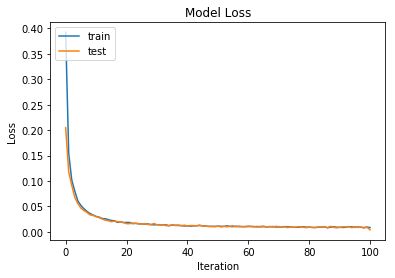

In [17]:
char_s2s_ext.train()

The errors cascade - one small initial error can lead the decoding off on the wrong route. Beam search would resolve this.



In [64]:
char_s2s_ext.train()

Training for epoch 0
Training on batch 0 to 50000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 106s 2ms/step - loss: 0.0080 - acc: 0.3087 - val_loss: 0.0077 - val_acc: 0.3084
Training on batch 50000 to 100000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 112s 2ms/step - loss: 0.0095 - acc: 0.3079 - val_loss: 0.0103 - val_acc: 0.3074
Training on batch 100000 to 150000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 114s 2ms/step - loss: 0.0099 - acc: 0.3071 - val_loss: 0.0100 - val_acc: 0.3099
Training on batch 150000 to 200000 of 5001036
Train on 50000 samples, validate on 12500 samples
Epoch 1/1
50000/50000 [==============================] - 117s 2ms/step - loss: 0.0093 - acc: 0.3091 - val_loss: 0.0084 - val_acc: 0.3080
Training on batch 200000 to 250000 of 5001036
Train on

KeyboardInterrupt: 

In [65]:
char_s2s_ext.example_output(100)

------------------------------------------
Predicted word is: o c g i s i f a b i i p m p t f j n n p 
Actual word is: o n e  
---
Predicted word is: c u p s s s g i t e m p i n m n n g b p 
Actual word is: c o n t r o l  
---
Predicted word is: s p r g d i b f p n b r p i s n l p b b 
Actual word is: s u p e r v i s o r y  
---
Predicted word is: l i a c s p r g t n p n t k m n s p t n 
Actual word is: l o g i c  
---


/playground_data/content/notebooks/title_generation/char_gen.py:14: RuntimeWarning: divide by zero encountered in log
  preds = np.log(preds) / temperature


Predicted word is: r r i e i e f i i t n p p p n p g o g i 
Actual word is: r e s p e c t i v e  
---
Predicted word is: c v d e b g m g p l p p t n g s i i g p 
Actual word is: c a u s i n g  
---
Predicted word is: r v p r i l p t h s p m m t s s t n n n 
Actual word is: r e p r e s e n t a t i o n s  
---
Predicted word is: t s p i i p p p l p i n b i t g b s p i 
Actual word is: t h e  
---
Predicted word is: c o s s s l t n p n m k o p p o n g p b 
Actual word is: c h a n n e l s  
---
Predicted word is: t s m i e r p p b p n p o i m p g e i b 
Actual word is: t h e  
---
Predicted word is: f a h p p n b b t p g e n p b p p m g s 
Actual word is: f r o m  
---
Predicted word is: g l s t d e p p r p s n h o b r n i e g 
Actual word is: a d m i s s i o n  
---
Predicted word is: e m r e p l f t p p i p b n f n p t n p 
Actual word is: e a c h  
---
Predicted word is: r m s d p e g e g n i g n p i g p f p p 
Actual word is: r e c o r d  
---
Predicted word is: w h i d l s p e n p m p

Predicted word is: d h a d c l d i p t s p s p p g i n f p 
Actual word is: d m a  
---
Predicted word is: i t a k e p i n g n i n t n p l p p p n 
Actual word is: i n  
---
Predicted word is: t s p i i c p p r p n f i p g p b n i n 
Actual word is: t h e  
---
Predicted word is: a r s b i i p n n p i p i n p p p g p t 
Actual word is: a n d  
---


Ah - this isn't working at all. Why am I getting a low loss?!

### Beam Search Decoding

Machine Learning Mastery has an article [here](https://machinelearningmastery.com/beam-search-decoder-natural-language-processing/) that describes how to implement a beam search. However, in the comments this is criticised for being too simplistic. Here is [another example](https://gist.github.com/udibr/67be473cf053d8c38730) of a beam search for keras. Here is an example slide: http://www.cs.cmu.edu/afs/cs/academic/class/46927-f97/slides/Lec3/sld023.htm.

The beam search algorithm:

* Initialise probabilities to 1 for start token;
* Predict the list of probabilities for the start token;
* Update scores as score * -log(each of k top probs);
* Select the k top scores;
* Build k sequences for each of the k top probabilities  = start token + prediction for 0 to k-1
* Predict next token for each sequence - update scores and sequences.

We need to keep track of states along the sequence.

We need to adapt our `_predict_from_seq()` method.

Is it easier to update as arrays and then only select the top k.

Data structures:
* scores
* sequences (or (token, state) as sequence elements)
* states

Input:
* initial_encoded_state
* k

Output:
* k sequences with top scores

For each timestamp, for each element in score, we have a set of predicted probabilities.

(Aside: Transformer network - https://github.com/Lsdefine/attention-is-all-you-need-keras/blob/master/transformer.py)

In [195]:
from keras.utils import to_categorical

import math

def sample(preds, temperature=1.0):
    """ Helper function to sample an index from a probability array. """
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return probas

def _predict_from_seq(self, input_data, k, temp=1.0):
    """ Predict output text from input text. """
    state = input_data.reshape(1, self.latent_dim)
    ndt = self.num_decoder_tokens  # Just shorten the variable name 
    output_sequences = []
    # Initialise data storage - char sequence, state sequence, scores
    sequences = [[[self.output_dictionary["_SOW_"]], [state], 0.0]]
    
    for _ in range(self.decoder_seq_length):
        # Create an empty array to hold the scores in each pass
        new_scores = np.zeros(shape=(len(sequences)*ndt))
        temp_states = []
        #print([s[0] for s in sequences])
        for i, seq in enumerate(sequences):
            #print(i, seq[0])
            # Get most recent state as last entry in state sequence
            prev_state = seq[1][-1]
            # Get most recent score
            prev_score = seq[2]
            # Get current token sequence
            prev_seq = seq[0]
            # Get previous token and convert to one-hot
            prev_token = to_categorical(prev_seq[-1], num_classes=ndt).reshape(1, 1, ndt)
            
            # Predict token probabilities using previous state and token for sequence
            yhat, state = self.infdec.predict([prev_state, prev_token])
            # Unpack yhat array of probabilities
            #yhat = sample(yhat[0, 0, :])
            yhat = yhat[0,0,:]
            # print(yhat)
            # We can put a sample line in here to modify yhat
            # Save state in temporary array
            temp_states.append(state)
            # As we are taking the log do we not sum the scores?
            new_scores[i*ndt:(i+1)*ndt] = prev_score+-np.log(yhat) # We could do this inplac
            # print(new_scores)
            # Actually I only need to look at the top k for each sequence, then further distill these down to the top k
            # across all sequences - maybe one for optimising later
            
        # Outside of loop we want to pick the k highest scores
        # Each sequence has a set of scores equal in size to num_decoder_tokens- i.e. k*n_d_t scores in total
        # We want to select the k highest scores across all scores in total - but then we need to know
        # We just modulo k on the index to find the indice and int(index/num_decoder_tokens) to find k
        
        # Then update the sequences to reflect these k highest scores
            
        # select top k scores -as we are minimising these are at bottom of list
        top_k_indices = np.argsort(new_scores)[:k].tolist()
        #print(new_scores[top_k_indices])
        #print(top_k_indices)
        new_sequences = []
        seqs_to_delete = []
        for index in top_k_indices:
            seq_select = int(index/ndt)
            #print("Selected seq: ", seq_select)
            #print("Length of sequences: ", len(sequences))
            new_token = index % ndt # this is the token index
            # This is equivalent to argmax - but should we actually be sampling?
            new_seq = sequences[seq_select][0] + [new_token]
            new_state_seq = sequences[seq_select][1] + [temp_states[seq_select]]
            #print(new_scores[index])
            entry = (new_seq, new_state_seq, new_scores[index])
            # If predicted token is end token
            if new_token == self.output_dictionary["_EOW_"]:
                # Add data for output
                output_sequences.append(entry)
                # Reduce k by 1
                k -= 1
            else:
                # Add to list of new sequences to use
                new_sequences.append(entry)
        sequences = new_sequences
        if k == 0:
            break
    
    # Sort list in reverse "score" order
    output_sequences.sort(key=lambda x: x[2])
    return output_sequences

The - turns it into a minimisation problem! I've been picking the most unlikely sequences!

In [196]:
input_data = char_s2s.input_test_data[15]
output_data = char_s2s.output_test_data[15]
seqs = _predict_from_seq(char_s2s, input_data, 5)

In [197]:
output_data

[1, 20, 3, 16, 13, 7, 6, 2]

In [198]:
for seq, state, score in seqs:
    print("Input test data is:", char_s2s._seq2text(output_data), "\n")
    print(score, char_s2s._seq2text(seq))

Input test data is: r a n k e d  

1.661349892616272 r a n k e d 
Input test data is: r a n k e d  

2.318960428237915 r e v e e 
Input test data is: r a n k e d  

3.498708724975586 r e a l h i n e 
Input test data is: r a n k e d  

3.629056692123413 r i s t e r 
Input test data is: r a n k e d  

4.727723121643066 r a n k e n t e s 


In [199]:
import random

def print_examples(self, number):
    num_test_titles = len(self.input_test_data)
    indices = random.sample(range(0, num_test_titles), number)
    print("------------------------------------------")
    for i in indices:
        input_sample = self.input_test_data[i]
        output_sample = self.output_test_data[i]
        seqs = _predict_from_seq(self, input_sample, 5)
        output_sample_text = self._seq2text(output_sample)
        print("\nActual word is: {} \n---".format(output_sample_text))
        for seq, state, score in seqs:
            o_string = (
                "Predicted word is: {0} with score {1}"
            )
            
            print(o_string.format(self._seq2text(seq), score))

In [200]:
print_examples(char_s2s, 100)

------------------------------------------

Actual word is: o f  
---
Predicted word is: o f  with score 0.0006058525759726763
Predicted word is: o u c t  with score 8.679265975952148
Predicted word is: o f c  with score 9.021984100341797
Predicted word is: o o  with score 9.345407485961914
Predicted word is: o u  with score 9.528753280639648

Actual word is: d e v i c e  
---
Predicted word is: d e v i c e  with score 0.0029975324869155884
Predicted word is: e e t w o r  with score 7.680788993835449
Predicted word is: d e c i c e  with score 7.939220428466797
Predicted word is: w e m m i n g  with score 8.304058074951172
Predicted word is: d e v i c i  with score 8.77090835571289

Actual word is: f i r s t  
---
Predicted word is: f i r s t  with score 0.005848006810992956
Predicted word is: f i r s n  with score 6.683882236480713
Predicted word is: s i r e g  with score 7.598910331726074
Predicted word is: f i r e n  with score 7.643312931060791
Predicted word is: t i r n  with score


Actual word is: i l l u m i n a t e d  
---
Predicted word is: i l l u g r o p t i o n  with score 4.530892848968506
Predicted word is: o u t l a t e d  with score 4.658166408538818
Predicted word is: o u t l a t e  with score 4.915664196014404
Predicted word is: i l l i g n o m e d  with score 5.16035270690918
Predicted word is: i l l i g u t i v e  with score 5.437795162200928

Actual word is: d r i v e n  
---
Predicted word is: d r i c e s  with score 3.088684320449829
Predicted word is: d r i v e n  with score 3.908629894256592
Predicted word is: d e n c e r s  with score 4.241482734680176
Predicted word is: d r i n t e d  with score 4.340156555175781
Predicted word is: d r i v e n t  with score 4.717126846313477

Actual word is: r o u t i n e  
---
Predicted word is: e a n c e  with score 2.2805418968200684
Predicted word is: i p e r a n t  with score 2.4373419284820557
Predicted word is: o p t i m n s  with score 2.7541708946228027
Predicted word is: a p r e c e r  with score 2


Actual word is: p l u r a l i t y  
---
Predicted word is: p l u r a l i t y  with score 0.011723889037966728
Predicted word is: p o u r e r i a l  with score 6.384951114654541
Predicted word is: p l u r a n i t y  with score 7.605269432067871
Predicted word is: p l u r a l i c e l  with score 7.951265811920166
Predicted word is: p u r r e n t e n c i v e  with score 8.99815845489502

Actual word is: a  
---
Predicted word is: a  with score 0.0006665560649707913
Predicted word is: w  with score 8.560648918151855
Predicted word is: b  with score 9.210902214050293
Predicted word is: e  with score 9.33383560180664
Predicted word is: l  with score 9.730419158935547

Actual word is: d e t e c t i o n  
---
Predicted word is: d e t e c t i o n  with score 0.05333971232175827
Predicted word is: d i t e  with score 5.0716352462768555
Predicted word is: d y n e  with score 5.4352803230285645
Predicted word is: d i t e c t i o  with score 5.566892623901367
Predicted word is: d y b e c e l  with


Actual word is: v o l u m e  
---
Predicted word is: v o l u m e  with score 0.1608767956495285
Predicted word is: v o l u m  with score 4.200084209442139
Predicted word is: c o m p e c t e  with score 4.228625774383545
Predicted word is: v o l u b r e  with score 4.680570602416992
Predicted word is: v o t u b  with score 4.801225662231445

Actual word is: a c c e s s  
---
Predicted word is: a c c e s s  with score 0.06131990626454353
Predicted word is: a c c u s  with score 4.87781286239624
Predicted word is: p r o c e s s e  with score 5.347423553466797
Predicted word is: r o c e s t  with score 5.917101860046387
Predicted word is: r e t e r t  with score 6.2648210525512695

Actual word is: t h e  
---
Predicted word is: t h e  with score 0.0004572269681375474
Predicted word is: t h  with score 9.038466453552246
Predicted word is: h h  with score 9.3350248336792
Predicted word is: n h e  with score 9.627456665039062
Predicted word is: h h m  with score 9.925104141235352

Actual wor

We need to watch out for floating point overflow!

The right spelling seems to be in there - but the scores are a bit whiffy. 

In [111]:
char_s2s.example_output(4)

------------------------------------------
Predicted word is: a d d r e s s e s 
Actual word is: a d d r e s s e s  
---
Predicted word is: n a t i v e 
Actual word is: n a t i v e  
---
Predicted word is: o f 
Actual word is: o f  
---
Predicted word is: w h e r e i n 
Actual word is: w h e r e i n  
---


In [82]:
int(28/29)

0

In [18]:
[[list(), 1.0]]

[[[], 1.0]]

In [51]:
[1,2,4] + [3]

[1, 2, 4, 3]

In [59]:
a = 4
a -= 1
a

3

In [32]:
int(4778/2500)

1

In [33]:
4778 % 2500

2278

In [25]:
import math
math.log(0.01)

-4.605170185988091

In [27]:
a = np.array([0.1, 0.2, 0.3])
b = np.log(a)
c = 3.0 * -b
print(c)

[6.90775528 4.82831374 3.61191841]


In [28]:
# Use argsort where -c reverses array and :3 takes top 3 items to return top 2 indices
np.argsort(-c)[:2]

array([0, 1])

In [31]:
# Use argsort where -c reverses array and :3 takes top 3 items to return top 2 indices
a1 = np.array([5, 2, 6, -1, 3])
d = np.argsort(-a1)[:2]
print(d, a1[d])


[2 0] [6 5]


In [53]:
type(a1[d[0]])

numpy.int64

In [49]:
d.tolist()

[2, 0]

In [47]:
e = np.zeros(shape=(4))
e[1:4] = a
e

array([0. , 0.1, 0.2, 0.3])

In [38]:
np.concatenate((d, d))

array([2, 0, 2, 0])